In [4]:
%pip install seaborn
%pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt


In [7]:
file_path = r"/Users/anjanapro/Desktop/machine learning/flight_delay_prediction/notebooks/merged_data_with_labels.csv"
df = pd.read_csv(file_path)

classifier_columns = ["windspeedKmph", "winddirDegree", "precipMM", "visibility", "pressure", 
                      "cloudcover", "DewPointF", "WindGustKmph", "tempF", "WindChillF", "humidity", "DepDelayMinutes"]

# read the file from a filepath to its csv into a dataframe
file_path_train = r"/Users/anjanapro/Desktop/machine learning/flight_delay_prediction/notebooks/clf_train_data.csv"
file_path_test = r"/Users/anjanapro/Desktop/machine learning/flight_delay_prediction/notebooks/clf_test_data.csv"
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

# assuming 'ArrDel15' is the target variable
X_train = df_train.drop('ArrDel15', axis=1) 
y_train = df_train['ArrDel15']  

X_test = df_test.drop('ArrDel15', axis=1) 
y_test = df_test['ArrDel15']  


# based on how the testing set for classification and regression is the same based on how it was structured for resampling...
# all we need is the corresponding Ddelays which is in the "ArrDelayMinutes" column of the reg_test_data, where the X_test is the same for both 
# classificationa and regression
file_path_test_reg = r"/Users/anjanapro/Desktop/machine learning/flight_delay_prediction/notebooks/reg_test_data.csv"
df_test_reg = pd.read_csv(file_path_test_reg)
X_test_reg = df_test_reg.drop('ArrDelayMinutes', axis=1) 
y_test_reg = df_test_reg['ArrDelayMinutes']  

In [8]:
# train best-performing classifier as chosen by the highest F1-score among the classifiers (Decision Tree Classifier)
classifier = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=8, min_samples_leaf=5)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=42)

In [9]:
y_pred_clf = classifier.predict(X_test)

In [20]:
# create a filtered dataset of the original dataset that contains only information about delayed flights to train regressors on
delayed_flights = df[df["ArrDel15"] == 1]

In [21]:
X_train_delayed, X_test_delayed, y_train_delayed, y_test_delayed = train_test_split(delayed_flights[classifier_columns], delayed_flights["ArrDelayMinutes"], test_size=0.2, random_state=42)

In [22]:
# Extra Trees Regressor trained on only delayed flight information
et_regressor = ExtraTreesRegressor()
et_regressor.fit(X_train_delayed, y_train_delayed)

ExtraTreesRegressor()

In [34]:
# filter the prediction output of the classifier to only consist of the corresponging X_test feature values 
# and Delay Minutes of the predicted delayed flights
df_reg_X_test = X_test[y_pred_clf == 1]
df_reg_y_test = y_test_reg[y_pred_clf == 1]


In [35]:
# move DepDelayMinutes to the back to match the order in which features were fitted in the moddle
depDelay = df_reg_X_test["DepDelayMinutes"]

df_reg_X_test= df_reg_X_test.drop('DepDelayMinutes', axis=1) 


In [36]:
df_reg_X_test = pd.concat([df_reg_X_test, depDelay], axis=1)

In [37]:
# prediction of the pipeline with the Extra Trees Regressor
y_pred_et = et_regressor.predict(df_reg_X_test)

AttributeError: module 'matplotlib' has no attribute 'show'

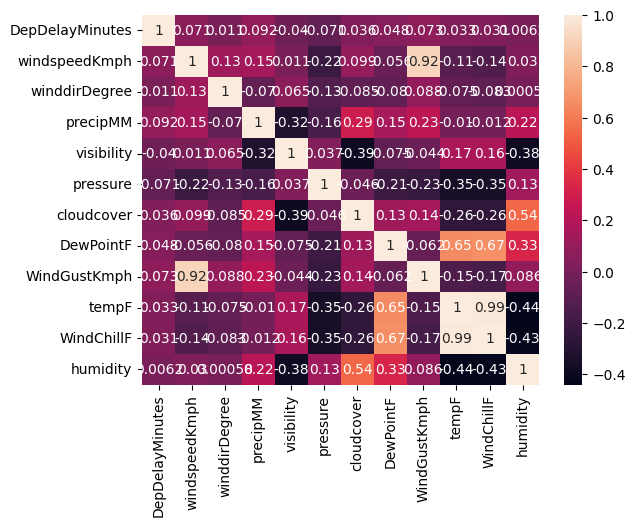

In [16]:
# FEATURE ENGINEERING
correlation = X_train.corr()

sns.heatmap(correlation, annot=True)  
plt.show()


AttributeError: module 'matplotlib' has no attribute 'show'

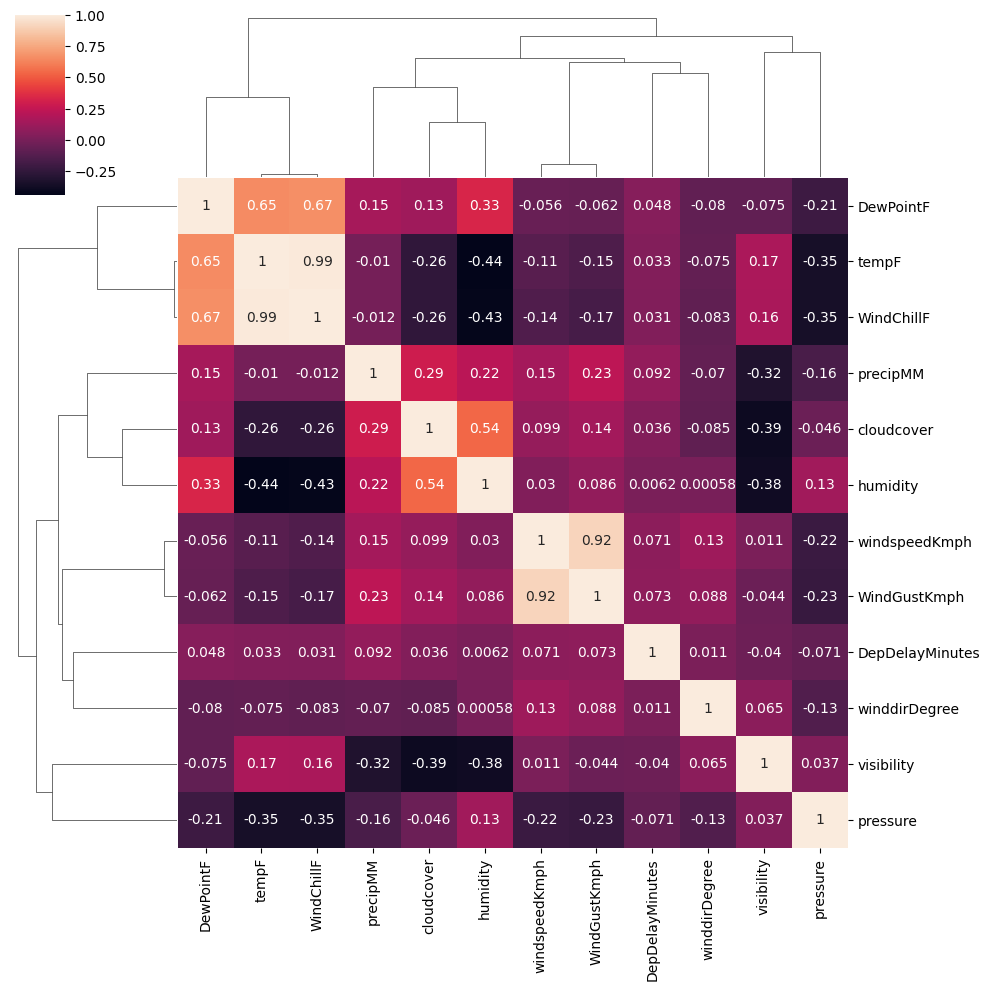

In [17]:
sns.clustermap(correlation, annot=True)
plt.show()

In [28]:
# get feature importances
feature_importances_clf = classifier.feature_importances_

# create dataframe with feature names and importance scores
feature_imp_clf = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances_clf})

# sort features by importance
feature_imp_clf = feature_imp_clf.sort_values(by='importance', ascending=False)

# top 6 features for stage 1
top_6_features_stage1 = feature_imp_clf['feature'].head(6).tolist()

print(top_6_features_stage1)


['DepDelayMinutes', 'precipMM', 'WindChillF', 'pressure', 'DewPointF', 'winddirDegree']


In [23]:
# get mean feature importance across all trees in the ensemble
feature_importances_reg = et_regressor.feature_importances_
mean_importance = np.mean(feature_importances_reg, axis=0)

# create a dataframe with feature names and importance scores
feature_imp_df = pd.DataFrame({'feature': X_train_delayed.columns, 'importance': mean_importance})

# sort features by importance 
feature_imp_df = feature_imp_df.sort_values(by='importance', ascending=False)

# top 6 features for stage 2
top_6_features_stage2 = feature_imp_df['feature'].head(6).tolist()

print(top_6_features_stage2)


['windspeedKmph', 'winddirDegree', 'precipMM', 'visibility', 'pressure', 'cloudcover']


In [50]:
combined_importances = (feature_importances_clf + feature_importances_reg) / 2

combined_features_df = pd.DataFrame({
    'feature': X_train_delayed.columns,
    'importance': combined_importances
})

combined_features_df = combined_features_df.sort_values(by='importance', ascending=False)

top_6_features_combined = combined_features_df['feature'].head(6).tolist()
print("Top 6 features across both models:", top_6_features_combined)



Top 6 features across both models: ['windspeedKmph', 'DepDelayMinutes', 'visibility', 'humidity', 'winddirDegree', 'pressure']


In [65]:
clf_X6_train = X_train[top_6_features_combined]
clf_X6_test = X_test[top_6_features_combined]

reg_X6_train = X_train_delayed[top_6_features_combined]
reg_X6_test = X_test_delayed[top_6_features_combined]

In [67]:
clf_top_6 = DecisionTreeClassifier()
clf_top_6.fit(clf_X6_train, y_train)

DecisionTreeClassifier()

In [68]:
reg_top6 = ExtraTreesRegressor()
reg_top6.fit(reg_X6_train, y_train_delayed)

ExtraTreesRegressor()

In [69]:
df_reg_X_test_top6 = df_reg_X_test[top_6_features_combined]
y_pred_et_top6 = reg_top6.predict(df_reg_X_test_top6)

In [71]:
import os
import csv

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def evaluate_and_save_classification_results(model_name, y_test, y_pred, output_file="pipeline_results.csv"):
    report = {}
    # calculate MSE; the average squared difference between predicted and actual values
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # calculate the RMSE; the square root of MSE
    # easier to interpret in the same units as the target variable (delay duration in minutes).
    rmse = np.sqrt(mse)

    # calculate R-squared
    # proportion of variance in target variable given by model
    # ranges from 0 to 1, with higher values indicating a better fit
    r2 = r2_score(y_test, y_pred)

    metrics = {
        'Model': [model_name],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'R-squared': [r2]
    }
    
    # convert to dataframe
    metrics_df = pd.DataFrame(metrics)
    
    # append to csv file
    if not os.path.isfile(output_file):
        metrics_df.to_csv(output_file, index=False)
    else:
        metrics_df.to_csv(output_file, mode='a', header=False, index=False)


evaluate_and_save_classification_results("Top 6 features in Decision Tree and Extra Trees Pipeline ", df_reg_y_test, y_pred_et_top6)